In [1]:
!pip install -Uqq pyts fastbook pandas-ta

In [2]:
import datetime as dt
import os
import warnings
import numpy as np
import pandas as pd
import pywt
import pywt.data
import re
import gc
import pandas_ta as ta
from pyts.image import GramianAngularField
from PIL import Image as im
import matplotlib.image

import fastbook
fastbook.setup_book()
from fastbook import *

In [4]:
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
INPUT_SIZE = 30
RAW_INPUT_SIZE = 100
THRESHOLD = 0.97
TRADING_PERCENT = 0.1
INITIAL_USD_BALANCE = 1000
STOP_PROFIT = 0.004
STOP_LOSS = 0.004
ORDER_LIFE = 5

In [ ]:
wavelet_type = 'sym15'
w = pywt.Wavelet(wavelet_type)
def denoise(data):
    if len(data) > 0:
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev)
        coeffs[-1] = np.zeros_like(coeffs[-1])
        datarec = pywt.waverec(coeffs, wavelet_type)
        return datarec
    else:
        return data

In [ ]:
df = pd.read_csv("../input/binance-1m/binance.csv", header=0,
                 names=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'].apply(lambda x: pd.to_datetime(x))

In [ ]:

def calc_label(dataset, position):
    price = dataset['close'].to_numpy()[position]
    stop_loss = STOP_LOSS * price
    stop_profit = STOP_PROFIT * price
    label = "wait"
    bearish_stop_loss = price + stop_loss
    bearish_stop_profit = price - stop_profit
    bullish_stop_loss = price - stop_loss
    bullish_stop_profit = price + stop_profit
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if low_price > bullish_stop_loss:
            if max_price >= bullish_stop_profit:
                label = "buy"
                break
        else:
            break
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if max_price < bearish_stop_loss:
            if low_price <= bearish_stop_profit:
                label = "sell"
                break
        else:
            break
    return label

In [ ]:
L = len(df['close'])
df_labels = [None]*L
for i in range(0, L-ORDER_LIFE):
    df_labels[i] = calc_label(df, i)

df['label'] = df_labels

In [ ]:

df = df.iloc[:-ORDER_LIFE].reset_index(drop=True).copy()

In [ ]:
DS_LENGTH = len(df['close'])
input_open = [None]*DS_LENGTH
input_high = [None]*DS_LENGTH
input_low = [None]*DS_LENGTH
input_close = [None]*DS_LENGTH
input_volume = [None]*DS_LENGTH
input_timestamp = [None]*DS_LENGTH

In [ ]:
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_open[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].open.copy()
df_label = df[['label']].copy()
df_label['input_open'] = input_open
df_label = df_label.iloc[RAW_INPUT_SIZE:]
df_label = df_label[df_label['label'] != 'wait'].reset_index(drop=True).copy()
df_label.to_json('/kaggle/working/input_open.json', orient='records')
del df_label
gc.collect()

In [ ]:
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_high[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].high.copy()
df_label = df[['label']].copy()
df_label['input_high'] = input_high
df_label = df_label.iloc[RAW_INPUT_SIZE:]
df_label = df_label[df_label['label'] != 'wait'].reset_index(drop=True).copy()
df_label.to_json('/kaggle/working/input_high.json', orient='records')
del df_label
gc.collect()

In [ ]:
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_low[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].low.copy()
df_label = df[['label']].copy()
df_label['input_low'] = input_low
df_label = df_label.iloc[RAW_INPUT_SIZE:]
df_label = df_label[df_label['label'] != 'wait'].reset_index(drop=True).copy()
df_label.to_json('/kaggle/working/input_low.json', orient='records')
del df_label
gc.collect()

In [ ]:
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_close[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close.copy()
df_label = df[['label']].copy()
df_label['input_close'] = input_close
df_label = df_label.iloc[RAW_INPUT_SIZE:]
df_label = df_label[df_label['label'] != 'wait'].reset_index(drop=True).copy()
df_label.to_json('/kaggle/working/input_close.json', orient='records')
del df_label
gc.collect()

In [ ]:
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_volume[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].volume.copy()
df_label = df[['label']].copy()
df_label['input_volume'] = input_volume
df_label = df_label.iloc[RAW_INPUT_SIZE:]
df_label = df_label[df_label['label'] != 'wait'].reset_index(drop=True).copy()
df_label.to_json('/kaggle/working/input_volume.json', orient='records')
del df_label
gc.collect()

In [ ]:
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_timestamp[i] = df.iloc[i+1-RAW_INPUT_SIZE:i +
                                     1].timestamp.copy().reset_index(drop=True)
df_label = df[['label']].copy()
df_label['input_timestamp'] = input_timestamp
df_label = df_label.iloc[RAW_INPUT_SIZE:]
df_label = df_label[df_label['label'] != 'wait'].reset_index(drop=True).copy()
df_label.to_json('/kaggle/working/input_timestamp.json', orient='records')

In [ ]:
DS_LENGTH = len(df_label['label'])
del df_label
del df
gc.collect()

In [ ]:
denoised_input_open = [None]*DS_LENGTH
denoised_input_high = [None]*DS_LENGTH
denoised_input_low = [None]*DS_LENGTH
denoised_input_close = [None]*DS_LENGTH
denoised_input_volume = [None]*DS_LENGTH

df = pd.read_json('/kaggle/working/input_open.json')
df_denoised = df[['label']].copy()
for i in range(0, DS_LENGTH):
    denoised_input_open[i] = denoise(df['input_open'][i])
del df

df = pd.read_json('/kaggle/working/input_high.json')
for i in range(0, DS_LENGTH):
    denoised_input_high[i] = denoise(df['input_high'][i])
del df

df = pd.read_json('/kaggle/working/input_low.json')
for i in range(0, DS_LENGTH):
    denoised_input_low[i] = denoise(df['input_low'][i])
del df

df = pd.read_json('/kaggle/working/input_close.json')
for i in range(0, DS_LENGTH):
    denoised_input_close[i] = denoise(df['input_close'][i])
del df

df = pd.read_json('/kaggle/working/input_volume.json')
for i in range(0, DS_LENGTH):
    denoised_input_volume[i] = denoise(df['input_volume'][i])
del df

df = pd.read_json('/kaggle/working/input_timestamp.json')



In [ ]:
df_denoised['denoised_input_open'] = pd.Series(denoised_input_open).copy()
df_denoised['denoised_input_high'] = pd.Series(denoised_input_high).copy()
df_denoised['denoised_input_low'] = pd.Series(denoised_input_low).copy()
df_denoised['denoised_input_close'] = pd.Series(denoised_input_close).copy()
df_denoised['denoised_input_volume'] = pd.Series(denoised_input_volume).copy()
df_denoised['input_timestamp'] = pd.Series(df['input_timestamp']).copy()

del df
gc.collect()

In [13]:
ind_list = ['qstick', 't3', 'cti', 'mad', 'ha', 'squeeze', 'aroon', 'bbands', 'kc', 'vwap', 'stoch']
ind_columns = ['qstick', 't3', 'cti', 'mad', 'HA_low', 'SQZ_20_2.0_20_1.5', 'AROONU_14', 'BBU_5_2.0', 'KCBe_20_2', 'vwap', 'STOCHd_14_3_3']

In [ ]:
DS_LENGTH = len(df_denoised['denoised_input_open'])
DS_LENGTH

In [ ]:
for indi in ind_list:
    print(indi)
    indi_result = {}
    new_cols = []
    for i in range(0, DS_LENGTH):
        indi_input = pd.DataFrame()
        indi_input['open'] = df_denoised['denoised_input_open'][i].copy()
        indi_input['high'] = df_denoised['denoised_input_high'][i].copy()
        indi_input['low'] = df_denoised['denoised_input_low'][i].copy()
        indi_input['close'] = df_denoised['denoised_input_close'][i].copy()
        indi_input['volume'] = df_denoised['denoised_input_volume'][i].copy()
        indi_input['timestamp'] = [pd.to_datetime(x) for x in df_denoised['input_timestamp'][i]]
        indi_input.set_index(pd.DatetimeIndex(
            indi_input["timestamp"]), inplace=True)
        indi_fn = getattr(indi_input.ta, indi)
        data = indi_fn()
        if len(new_cols) == 0:
            if not isinstance(data, pd.Series):
                new_cols = new_cols + data.columns.to_numpy().tolist()
            else:
                new_cols = new_cols + [indi]
            for col_name in new_cols:
                indi_result[col_name] = [None]*DS_LENGTH
        for col_name in new_cols:
            if not isinstance(data, pd.Series):
                indi_result[col_name][i] = data[col_name]
            else:
                indi_result[col_name][i] = data
    for col_name in new_cols:
        if col_name in ind_columns:
            df_denoised[col_name] = indi_result[col_name]


In [ ]:
gaf_transformer = GramianAngularField(method='difference', image_size=INPUT_SIZE)
df_gaf_input_open = [None]*DS_LENGTH
df_gaf_input_high = [None]*DS_LENGTH
df_gaf_input_low = [None]*DS_LENGTH
df_gaf_input_close = [None]*DS_LENGTH
df_gaf_input_volume = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if len(df_denoised['denoised_input_close'][i]) > 0:
        df_gaf_input_open[i] = gaf_transformer.fit_transform(
            df_denoised['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_high[i] = gaf_transformer.fit_transform(
            df_denoised['denoised_input_high'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_low[i] = gaf_transformer.fit_transform(
            df_denoised['denoised_input_low'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_close[i] = gaf_transformer.fit_transform(
            df_denoised['denoised_input_close'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_volume[i] = gaf_transformer.fit_transform(
            df_denoised['denoised_input_volume'][i][-INPUT_SIZE:].reshape(1, -1))
df_denoised['gaf_open'] = df_gaf_input_open
df_denoised['gaf_high'] = df_gaf_input_high
df_denoised['gaf_low'] = df_gaf_input_low
df_denoised['gaf_close'] = df_gaf_input_close
df_denoised['gaf_volume'] = df_gaf_input_volume
df_denoised.drop(columns=['denoised_input_open', 'denoised_input_high', 'denoised_input_low',
                 'denoised_input_close', 'denoised_input_volume', 'input_timestamp'])
df_denoised = df_denoised.copy()
gc.collect()

In [ ]:
for col_name in ind_columns:
    print(col_name)
    gaf_col = [None]*DS_LENGTH
    for i in range(0, DS_LENGTH):
        if len(df_denoised['gaf_open'][i]) > 0:
            if isinstance(df_denoised[col_name][i], pd.Series):
                df_denoised[col_name][i].replace([np.inf, -np.inf], np.nan, inplace=True)
                df_denoised[col_name][i].fillna(value=0, inplace=True)
                gaf_col[i] = gaf_transformer.fit_transform(df_denoised[col_name][i][-INPUT_SIZE:].to_numpy().reshape(1, -1))
            else:
                df_denoised[col_name][i] = pd.Series(df_denoised[col_name][i])
                df_denoised[col_name][i].replace([np.inf, -np.inf], np.nan, inplace=True)
                df_denoised[col_name][i].fillna(value=0, inplace=True)
                gaf_col[i] = gaf_transformer.fit_transform(df_denoised[col_name][i][-INPUT_SIZE:].to_numpy().reshape(1, -1))
    df_denoised[col_name] = gaf_col


In [36]:
df_denoised.to_json('/kaggle/working/df_denoised.json', orient='records')
gc.collect()

In [14]:
df_train = pd.read_json('/kaggle/working/df_denoised.json')
pat = r'^(.*)_\d+.png'
images_path = '/kaggle/working/images/'
if not os.path.exists(images_path):
    os.makedirs(images_path)
files = get_image_files(images_path)
for f in files:
    os.remove(f)
files = get_image_files(images_path)
L = len(df_train['gaf_open'])
for i in range(0, L):
    i_open = np.array(df_train['gaf_open'].to_numpy()[i]).squeeze()
    i_high = np.array(df_train['gaf_high'].to_numpy()[i]).squeeze()
    i_low = np.array(df_train['gaf_low'].to_numpy()[i]).squeeze()
    i_close = np.array(df_train['gaf_close'].to_numpy()[i]).squeeze()
    i_volume = np.array(df_train['gaf_volume'].to_numpy()[i]).squeeze()
    inputs_list = [i_open, i_high, i_low, i_close, i_volume] + [np.array(df_train[col_name].to_numpy()[i]).squeeze() for col_name in ind_columns]
    rows_list = [inputs_list[i:i + 4] for i in range(0, len(inputs_list), 4)]
    image_rows = [np.concatenate(row) for row in rows_list]
    image = np.concatenate(image_rows, axis=1)
    label = df_train['label'].to_numpy()[i]
    matplotlib.image.imsave(images_path + label + '_' + str(i) + '.png', image)


    

In [15]:
images_path = '/kaggle/working/images/'
pat = r'^(.*)_\d+.png'
files = get_image_files(images_path)
dls = ImageDataLoaders.from_name_re(images_path, files, pat)
#dls.show_batch()
learn = vision_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(valley=0.0002754228771664202)

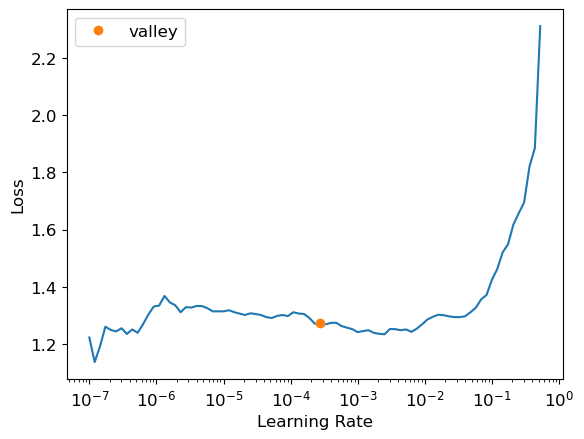

In [10]:
learn.lr_find()

In [16]:
learn.fine_tune(7, 0.0002754228771664202) #resnet34 the best so far

epoch,train_loss,valid_loss,error_rate,time
0,1.068068,0.753446,0.422839,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.931967,0.711300,0.396469,00:38
1,0.845408,0.688810,0.373997,00:38
2,0.747641,0.664611,0.364595,00:38
3,0.646340,0.661670,0.354047,00:38
4,0.579579,0.652013,0.344187,00:38
5,0.513583,0.657678,0.344646,00:38
6,0.489294,0.657124,0.346939,00:39


In [ ]:

#learn.show_results()
#learn.predict(files[0])

In [19]:
learn.export(fname='/kaggle/working/model.pkl')
